In [19]:
import gym
import numpy as np
import random
import sys
import matplotlib.pyplot as plt
import time





environment = gym.make("Taxi-v3")
environment.reset()
num_rows = 5
num_col = 5
num_episodes=5000
epsilon=0.1
alpha = 0.1
gamma = 0.99
nPas = 5
nDrop = 4


def get_action(Q_values,row,column,epsilon):
    p = np.random.rand()
    action = random.randint(0,Q_values.shape[-1]-1) if p<epsilon else np.argmax(Q_values[row,column,:])
    return action


def options(environment,state,Q_values,option_goal,epsilon=0.1):
    goal =  environment.locs
    optdone=False
    row,column,passenger,destination = environment.decode(state)

    if(row==goal[option_goal][0] and column==goal[option_goal][1]):
        optdone = True
        if option_goal==passenger:
            optact = 4
        elif option_goal == destination:
            optact = 5
        else:
            optact = np.random.randint(0,4)
    else:
        optact =  get_action(Q_values[option_goal],row,column,epsilon)
    return [optact,optdone]




def plot_Q(Q,message):
    DOWN = 1
    UP=0
    RIGHT=2
    LEFT=3
    plt.figure(figsize=(7,7))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='#ffffff', linewidths=1)
    plt.colorbar()
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        return -1 if a == UP else 1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()
########## This function is used to select the Option to execute based on epsilon greedy #####################################################3
def egreedy_policy(q_values,passenger,destination,epsilon):
  if q_values[passenger,destination].any() and random.random() > epsilon:
    return np.argmax(q_values[passenger,destination])
  action = random.randint(0,q_values.shape[-1]-1)
  return action

def new_options(environment,state,Q_values,option_goal,epsilon=0.1):
    goal=[(2,1)]
    optdone=False
    row,column,_,destination = environment.decode(state)
    if(row==goal[0][0] and column==goal[0][1] ):
        optdone = True
        if destination==0 or destination==2:
            optact = 3
        else:
            optact=2

    else:
        optact =  get_action(Q_values[option_goal],row,column,epsilon)
    return [optact,optdone]


####  Intra-Option Q learning with given options #######################################################
def Intra_Option_Q_Learning(environment,num_options):
    action_dim = environment.action_space.n
    Q_values_options = np.zeros((nPas,nDrop,num_options))
    updates_IOQL = np.zeros((nPas,nDrop,num_options))
    Q_options_actions = np.zeros((num_options,num_rows,num_col,action_dim-2))
    rewards=[]
    for i in range(num_episodes):
        state=environment.reset()
        done =False
        episode_reward = 0
        while not done:
            initial_state=state # This is to store the initial state of the taxi from which option started executing
            row,column,passenger,destination = environment.decode(state)
            option_state = nPas*destination+passenger
            option_goal = egreedy_policy(Q_values_options,passenger,destination,epsilon)
            option_done=False
            reward_option=0
            option_move=0
            while (option_done==False) and not done:
                optact,option_done = options(environment,state,Q_options_actions,option_goal,epsilon)
                row,column,passenger,destination=environment.decode(state)
                next_state,reward,done,_=environment.step(optact)
                reward_option = gamma*(reward_option)+reward
                row_next,column_next,passenger_next,destination_next = environment.decode(next_state)
                episode_reward+=reward
                reward_surr = reward
                if optact<4:
                    Q_options_actions[option_goal,row,column,optact] = Q_options_actions[option_goal,row,column,optact]+ alpha*(reward_surr+(1-option_done)*gamma*np.max(Q_options_actions[option_goal,row_next,column_next,:])-Q_options_actions[option_goal,row,column,optact])

                option_move+=1

                ### We check if any other option gives same action index ################
                for other_option in range(num_options):
                  other_option_action,other_option_done = options(environment,state,Q_options_actions,other_option,epsilon)
                  if(other_option_action==optact):
                    if other_option_done: ## Check if the option is done since update equations are different for terminal states and intermediate states
                      Q_values_options[passenger,destination,other_option]+=alpha*(reward+gamma*np.max(Q_values_options[passenger_next,destination_next,:])-Q_values_options[passenger,destination,other_option])
                    else:
                      Q_values_options[passenger,destination,other_option]+=alpha*(reward+gamma*Q_values_options[passenger_next,destination_next,other_option]-Q_values_options[passenger,destination,other_option])
                  updates_IOQL[passenger,destination,other_option]+=1
                ##########################################################################
                state = next_state
        rewards.append(episode_reward)
    return rewards,Q_options_actions

rewards_IOQL,Q_options = Intra_Option_Q_Learning(environment,4)
avg_rewards_IOQL = [np.average(rewards_IOQL[i:i+100]) for i in range(len(rewards_IOQL)-100)]

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


#Intra-Option Q-learning with New Options

In [20]:
import gym
import numpy as np
import random
import sys
import matplotlib.pyplot as plt
import time





environment = gym.make("Taxi-v3")
environment.reset()
num_rows = 5
num_col = 5
num_options = 5
num_episodes=5000
epsilon=0.1
alpha = 0.1
gamma = 0.99
nPas = 5
nDrop = 4

def get_action(Q_values,row,column,epsilon):
    p = np.random.rand()
    action = random.randint(0,Q_values.shape[-1]-1) if p<epsilon else np.argmax(Q_values[row,column,:])
    return action


def options(environment,state,Q_values,option_goal,epsilon=0.1):
    goal =  environment.locs
    optdone=False
    row,column,passenger,destination = environment.decode(state)

    if(option_goal!=4 and row==goal[option_goal][0] and column==goal[option_goal][1]):
        optdone = True
        if option_goal==passenger:
            optact = 4
        elif option_goal == destination:
            optact = 5
        else:
            optact = np.random.randint(0,4)
    else:
        optact =  get_action(Q_values[option_goal],row,column,epsilon)
    return [optact,optdone]

def new_options(environment,state,Q_values,option_goal,epsilon=0.1):
    goal=[(2,1)]
    optdone=False
    row,column,_,destination = environment.decode(state)
    if(row==goal[0][0] and column==goal[0][1] ):
        optdone = True
        if destination==0 or destination==2:
            optact = 3
        else:
            optact=2

    else:
        optact =  get_action(Q_values[option_goal],row,column,epsilon)
    return [optact,optdone]



def plot_Q(Q,message):
    DOWN = 1
    UP=0
    RIGHT=2
    LEFT=3
    plt.figure(figsize=(7,7))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='#ffffff', linewidths=1)
    plt.colorbar()
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        return -1 if a == UP else 1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()

########## This function is used to select the Option to execute based on epsilon greedy #####################################################3
def egreedy_policy(q_values,passenger,destination,epsilon):
  if q_values[passenger,destination].any() and random.random() > epsilon:
    return np.argmax(q_values[passenger,destination])
  choice = random.randint(0,q_values.shape[-1]-1)
  return choice

############### Intra-Option Q-Learning with new options ######################################################33
def Intra_Option_Q_Learning(environment):
    action_dim = environment.action_space.n
    Q_values_options = np.zeros((nPas,nDrop,num_options))
    updates_IOQL = np.zeros((nPas,nDrop,num_options))
    Q_options_actions = np.zeros((num_options,num_rows,num_col,action_dim-2))
    rewards=[]
    for i in range(num_episodes):
        state=environment.reset()
        done =False
        episode_reward = 0
        while not done:
            initial_state=state # This is to store the initial state of the taxi from which option started executing
            row,column,passenger,destination = environment.decode(state)
            option_state = nPas*destination+passenger
            option_goal = egreedy_policy(Q_values_options,passenger,destination,epsilon)
            option_done=False
            reward_option=0
            option_move=0
            while (option_done==False) and not done and option_goal!=4:
                optact,option_done = options(environment,state,Q_options_actions,option_goal,epsilon)
                row,column,passenger,destination=environment.decode(state)
                next_state,reward,done,_=environment.step(optact)
                reward_option = gamma*(reward_option)+reward
                row_next,column_next,passenger_next,destination_next = environment.decode(next_state)
                episode_reward+=reward
                reward_surr = reward
                if optact<4:
                    Q_options_actions[option_goal,row,column,optact] = Q_options_actions[option_goal,row,column,optact]+ alpha*(reward_surr+(1-option_done)*gamma*np.max(Q_options_actions[option_goal,row_next,column_next,:])-Q_options_actions[option_goal,row,column,optact])

                option_move+=1

                ### We check if any other option gives same action index ################
                for other_option in range(num_options):
                  other_option_action,other_option_done = options(environment,state,Q_options_actions,other_option,epsilon)
                  if(other_option_action==optact):
                    if other_option_done:
                      Q_values_options[passenger,destination,other_option]+=alpha*(reward+gamma*np.max(Q_values_options[passenger_next,destination_next,:])-Q_values_options[passenger,destination,other_option])
                    else:
                      Q_values_options[passenger,destination,other_option]+=alpha*(reward+gamma*Q_values_options[passenger_next,destination_next,other_option]-Q_values_options[passenger,destination,other_option])
                  updates_IOQL[passenger,destination,other_option]+=1
                ##########################################################################
                state = next_state
            while (option_done==False) and not done and option_goal==4:
                optact,option_done = new_options(environment,state,Q_options_actions,option_goal,epsilon)
                row,column,passenger,destination=environment.decode(state)
                next_state,reward,done,_=environment.step(optact)
                reward_option = gamma*(reward_option)+reward
                row_next,column_next,passenger_next,destination_next = environment.decode(next_state)
                episode_reward+=reward
                reward_surr = reward
                #if option_done:
                #  reward_surr=20
                if optact<4:
                    Q_options_actions[option_goal,row,column,optact] = Q_options_actions[option_goal,row,column,optact]+ alpha*(reward_surr+(1-option_done)*gamma*np.max(Q_options_actions[option_goal,row_next,column_next,:])-Q_options_actions[option_goal,row,column,optact])

                option_move+=1

                ### We check if any other option gives same action index ################
                for other_option in range(num_options):
                  other_option_action,other_option_done = options(environment,state,Q_options_actions,other_option,epsilon)
                  if(other_option_action==optact):
                    if other_option_done:
                      Q_values_options[passenger,destination,other_option]+=alpha*(reward+gamma*np.max(Q_values_options[passenger_next,destination_next,:])-Q_values_options[passenger,destination,other_option])
                    else:
                      Q_values_options[passenger,destination,other_option]+=alpha*(reward+gamma*Q_values_options[passenger_next,destination_next,other_option]-Q_values_options[passenger,destination,other_option])
                  updates_IOQL[passenger,destination,other_option]+=1
                ##########################################################################
                state = next_state
        rewards.append(episode_reward)
    return rewards,Q_options_actions

rewards_IOQL_new,Q_options_new = Intra_Option_Q_Learning(environment)
avg_rewards_IOQL_new = [np.average(rewards_IOQL_new[i:i+100]) for i in range(len(rewards_IOQL_new)-100)]

<Figure size 1000x500 with 0 Axes>

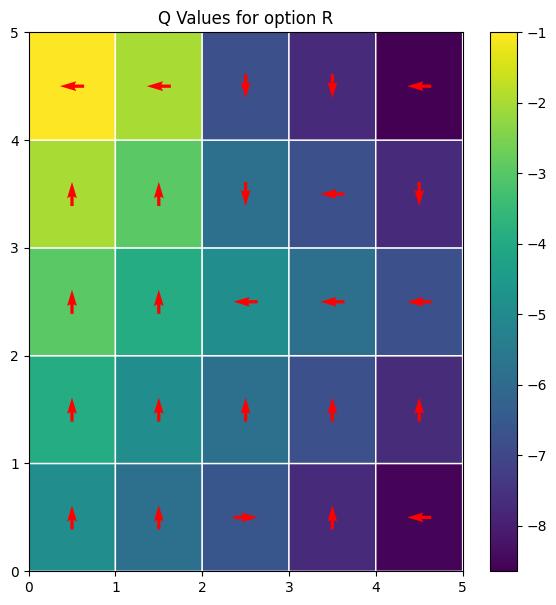

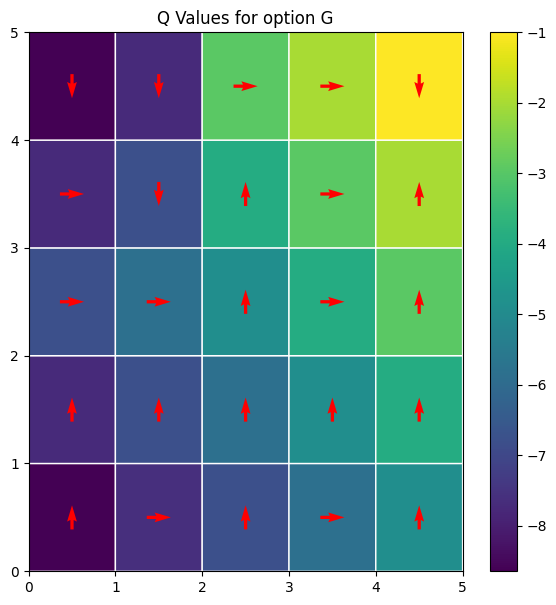

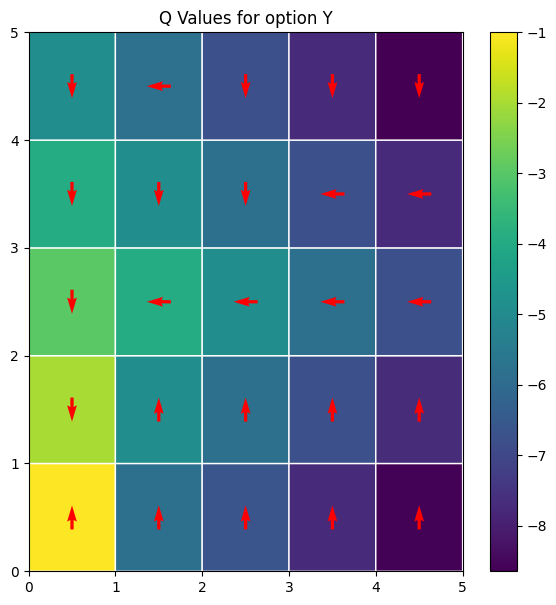

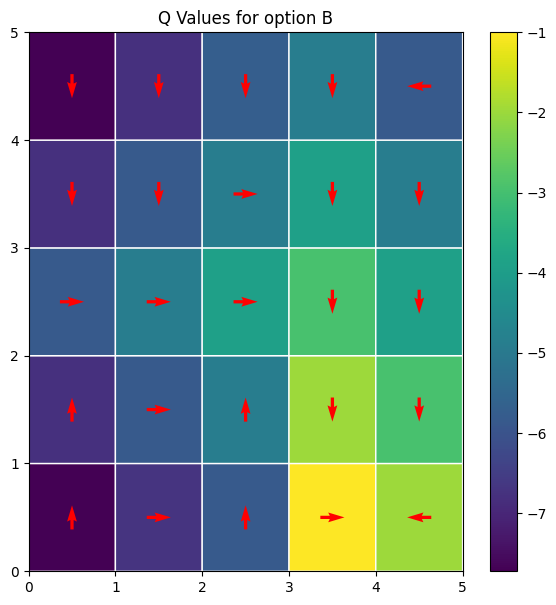

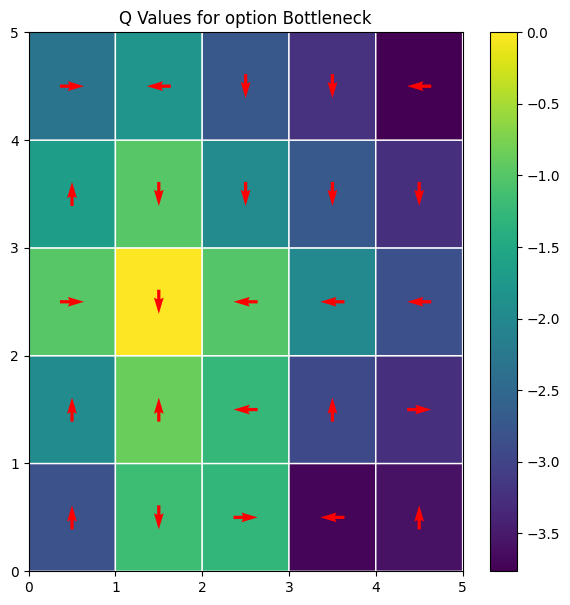

In [21]:
plt.figure(figsize = (10,5))
Options = ['R','G','Y','B','Bottleneck']
for i in range(5):
    plot_Q(np.flip(Q_options_new[i],axis=0),message="Q Values for option "+Options[i])

<Figure size 1000x400 with 0 Axes>

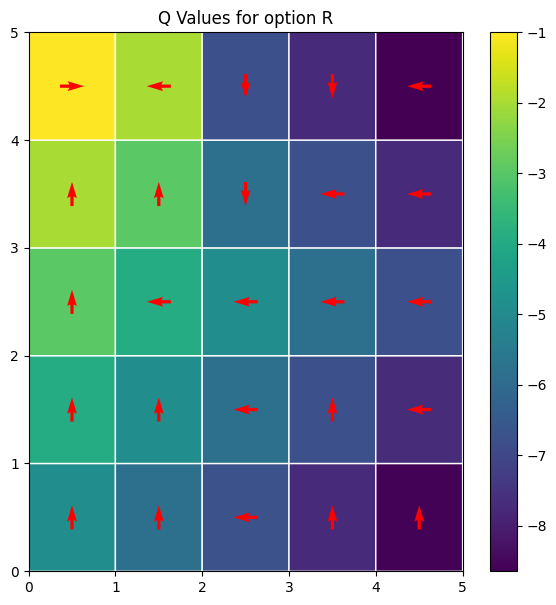

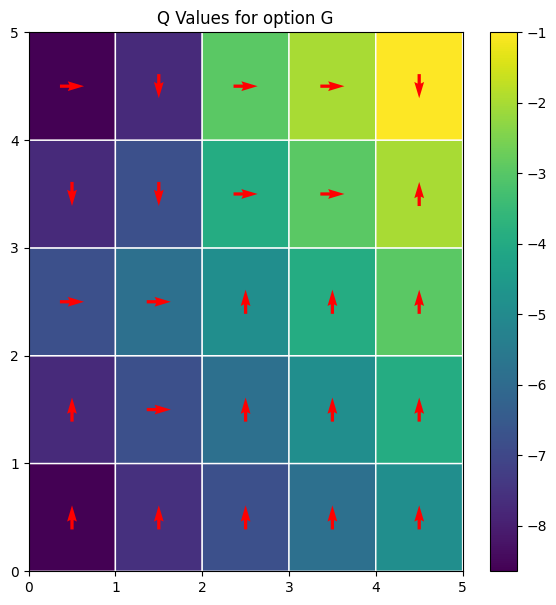

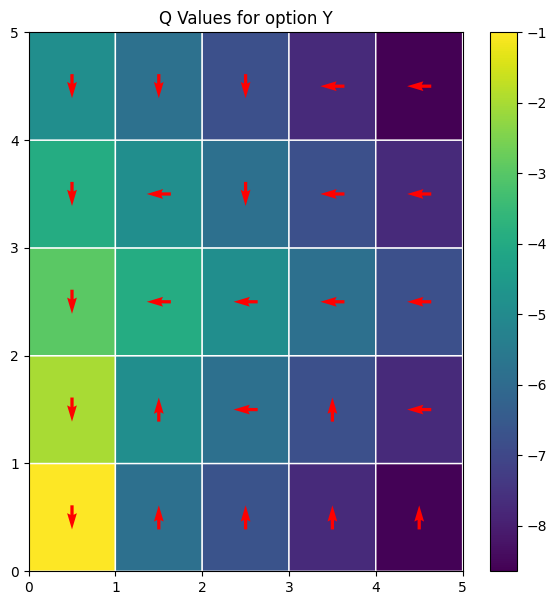

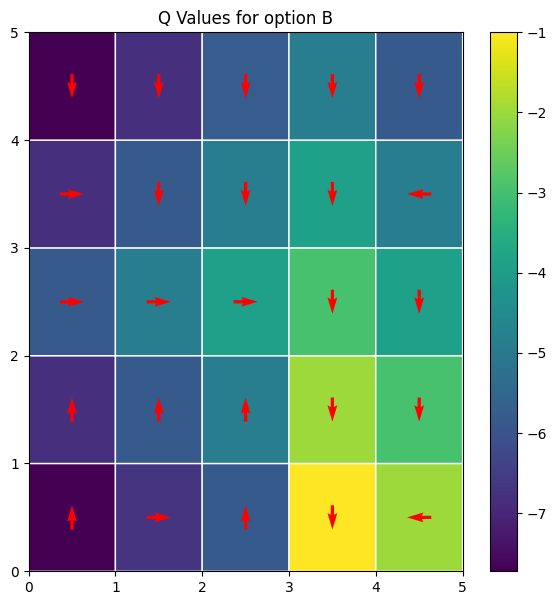

In [23]:
plt.figure(figsize = (10,4))
Options = ['R','G','Y','B']
for i in range(4):
    plot_Q(np.flip(Q_options[i],axis=0),message="Q Values for option "+Options[i])

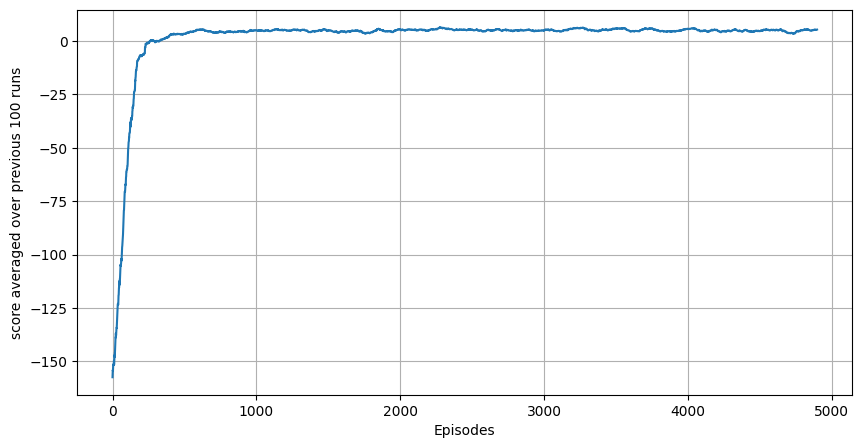

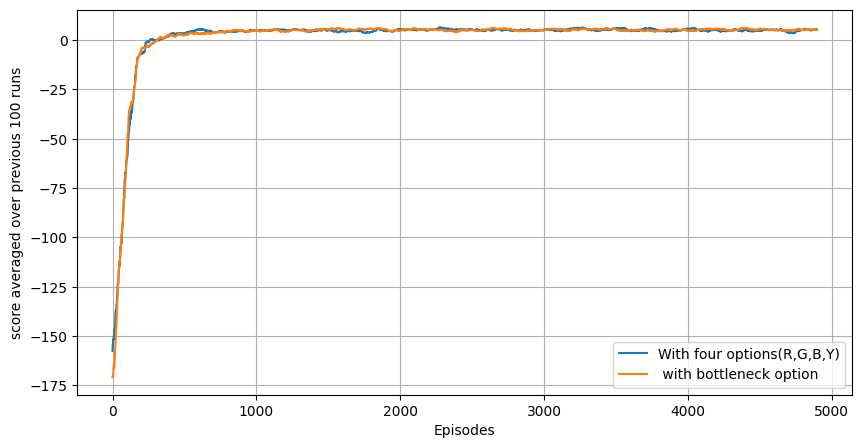

In [24]:
plt.figure(figsize = (10,5))
plt.plot(avg_rewards_IOQL)
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.figure(figsize = (10,5))
plt.plot(avg_rewards_IOQL)
plt.plot(avg_rewards_IOQL_new)
plt.legend(["With four options(R,G,B,Y)"," with bottleneck option"])
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.show()